In [1]:
import argparse

import numpy as np
import matplotlib.pyplot as plt

from keras.models import Model, Sequential
from keras.layers.core import Reshape, Dense, Dropout, Flatten
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import Conv2D, MaxPooling2D, UpSampling2D
from keras.layers.normalization import BatchNormalization
from keras.datasets import mnist
from keras.optimizers import Adam
from keras import initializers
from keras import backend as K
from datetime import datetime

Using TensorFlow backend.


In [2]:
K.set_image_data_format('channels_first')

In [3]:
class Data:
    """
    Define dataset for training GAN
    """
    def __init__(self, batch_size, z_input_dim):
        # load mnist dataset
        # 이미지는 보통 -1~1 사이의 값으로 normalization : generator의 outputlayer를 tanh로
        (X_train, y_train), (X_test, y_test) = mnist.load_data()
        self.x_data = ((X_train.astype(np.float32) - 127.5) / 127.5)
        self.x_data = self.x_data.reshape((self.x_data.shape[0], 1) + self.x_data.shape[1:])
        self.batch_size = batch_size
        self.z_input_dim = z_input_dim

    def get_real_sample(self):
        """
        get real sample mnist images

        :return: batch_size number of mnist image data
        """
        return self.x_data[np.random.randint(0, self.x_data.shape[0], size=self.batch_size)]

    def get_z_sample(self, sample_size):
        """
        get z sample data

        :return: random z data (batch_size, z_input_dim) size
        """
        return np.random.uniform(-1.0, 1.0, (sample_size, self.z_input_dim))

In [4]:
class GAN:
    def __init__(self, learning_rate, z_input_dim):
        """
        init params

        :param learning_rate: learning rate of optimizer
        :param z_input_dim: input dim of z
        """
        self.learning_rate = learning_rate
        self.z_input_dim = z_input_dim
        self.D = self.discriminator()
        self.G = self.generator()
        self.GD = self.combined()

    def discriminator(self):
        """
        define discriminator
        """
        D = Sequential()
        D.add(Conv2D(256, (5, 5),
                     padding='same',
                     input_shape=(1, 28, 28),
                     kernel_initializer=initializers.RandomNormal(stddev=0.02)))
        D.add(LeakyReLU(0.2))
        D.add(MaxPooling2D(pool_size=(2, 2), strides=2))
        D.add(Dropout(0.3))
        D.add(Conv2D(512, (5, 5), padding='same'))
        D.add(LeakyReLU(0.2))
        D.add(MaxPooling2D(pool_size=(2, 2), strides=2))
        D.add(Dropout(0.3))
        D.add(Flatten())
        D.add(Dense(256))
        D.add(LeakyReLU(0.2))
        D.add(Dropout(0.3))
        D.add(Dense(1, activation='sigmoid'))

        adam = Adam(lr=self.learning_rate, beta_1=0.5)
        D.compile(loss='binary_crossentropy', optimizer=adam, metrics=['accuracy'])
        return D

    def generator(self):
        """
        define generator
        """
        G = Sequential()
        G.add(Dense(512, input_dim=self.z_input_dim))
        G.add(LeakyReLU(0.2))
        G.add(Dense(128 * 7 * 7))
        G.add(LeakyReLU(0.2))
        G.add(BatchNormalization())
        G.add(Reshape((128, 7, 7), input_shape=(128 * 7 * 7,)))
        G.add(UpSampling2D(size=(2, 2)))
        G.add(Conv2D(64, (5, 5), padding='same', activation='tanh'))
        G.add(UpSampling2D(size=(2, 2)))
        G.add(Conv2D(1, (5, 5), padding='same', activation='tanh'))

        adam = Adam(lr=self.learning_rate, beta_1=0.5)
        G.compile(loss='binary_crossentropy', optimizer=adam, metrics=['accuracy'])
        return G

    def combined(self):
        """
        defien combined gan model
        """
        G, D = self.G, self.D
        D.trainable = False
        GD = Sequential()
        GD.add(G)
        GD.add(D)

        adam = Adam(lr=self.learning_rate, beta_1=0.5)
        GD.compile(loss='binary_crossentropy', optimizer=adam, metrics=['accuracy'])
        D.trainable = True
        return GD

In [5]:
class Model:
    def __init__(self, batch_size, epochs, learning_rate, z_input_dim, n_iter_D, n_iter_G):
        self.epochs = epochs
        self.batch_size = batch_size
        self.learning_rate = learning_rate
        self.z_input_dim = z_input_dim
        self.data = Data(self.batch_size, self.z_input_dim)

        # the reason why D, G differ in iter : Generator needs more training than Discriminator
        self.n_iter_D = n_iter_D
        self.n_iter_G = n_iter_G
        self.gan = GAN(self.learning_rate, self.z_input_dim)

        # print status
        batch_count = self.data.x_data.shape[0] / self.batch_size  #   60000 / 128
        print('Epochs:', self.epochs)
        print('Batch size:', self.batch_size)
        print('Batches per epoch:', batch_count)
        print('Learning rate:', self.learning_rate)
        print('Image data format:', K.image_data_format())

    def fit(self):
        self.d_loss = []
        self.g_loss = []
        for epoch in range(self.epochs):

            print('    [epochs:{}] {}'.format(epoch+1, datetime.now().strftime("%Y-%m-%d %H:%M:%S.%f")))
            # train discriminator by real data
            dloss = 0
            for iter in range(self.n_iter_D):
                print('        [n_iter_D:{}] {}'.format(iter+1, datetime.now().strftime("%Y-%m-%d %H:%M:%S.%f")))
                dloss = self.train_D()

            # train GD by generated fake data
            gloss = 0
            for iter in range(self.n_iter_G):
                print('        [n_iter_G:{}] {}'.format(iter+1, datetime.now().strftime("%Y-%m-%d %H:%M:%S.%f")))
                gloss = self.train_G()

            # save loss data
            self.d_loss.append(dloss)
            self.g_loss.append(gloss)

            # plot and save model each 20n epoch
            if (epoch+1) % 1 == 0:
                self.plot_generate_images(epoch, self.gan.G, examples=100)
                self.save_gan_model(epoch, self.gan.G, self.gan.D)
                print('[epoch={}] Discriminator loss:{} Generator loss:{}'.format(epoch+1, dloss, gloss))
                print('--- Time : {}'.format(datetime.now().strftime("%Y-%m-%d %H:%M:%S.%f"))) 
        
        # show loss after train
        self.plot_loss_graph(self.g_loss, self.d_loss)

    def train_D(self):
        """
        train Discriminator
        """

        # Real data
        real = self.data.get_real_sample()

        # Generated data
        z = self.data.get_z_sample(self.batch_size)
        generated_images = self.gan.G.predict(z)

        # labeling and concat generated, real images
        # Real과 Fake데이터를 Union All하고, 이에 대한 Label도 [0.9]과 [0]으로 준 다음 학습을 한다.
        x = np.concatenate((real, generated_images), axis=0)
        y = [0.9] * self.batch_size + [0] * self.batch_size

        #print('*'*100)
        #print('[type ] real:{}, generated_images:{}, x:{}, y:{}'.format(type(real), type(generated_images), type(x), type(y)))
        #print('[shape] real:{}, generated_images:{}, x:{}, y:{}'.format(real.shape, generated_images.shape, x.shape, len(y)))
        #print('[value] y:{}'.format(y))
        # train discriminator
        self.gan.D.trainable = True
        loss = self.gan.D.train_on_batch(x, y)
        return loss

    def train_G(self):
        """
        train Generator
        """

        # Generated data
        z = self.data.get_z_sample(self.batch_size)

        # labeling
        y = [1] * self.batch_size

        # train generator
        self.gan.D.trainable = False
        loss = self.gan.GD.train_on_batch(z, y)
        return loss

    def plot_loss_graph(self, g_loss, d_loss):
        """
        Save training loss graph
        """

        # show loss graph
        plt.figure(figsize=(10, 8))
        plt.plot(d_loss, label='Discriminator loss')
        plt.plot(g_loss, label='Generator loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        plt.savefig('mnist_images/mnist_gan_loss_graph.png')

    def plot_generate_images(self, epoch, generator, examples=100):
        """
        Save generated mnist images
        """
        # plt info
        dim = (10, 10)
        figsize = (10, 10)

        # generate images
        z = self.data.get_z_sample(examples)
        generated_images = generator.predict(z)

        # show images
        plt.figure(figsize=figsize)
        for i in range(generated_images.shape[0]):
            plt.subplot(dim[0], dim[1], i + 1)
            plt.imshow(generated_images[i].reshape((28, 28)), interpolation='nearest', cmap='gray_r')
            plt.axis('off')
        plt.tight_layout()
        plt.savefig('mnist_images/mnist_generated_image_epoch_%d.png' % epoch)

    def save_gan_model(self, epoch, generator, discriminator):
        """
        Save model trained generator, discriminator
        """

        # save G and D
        generator.save('mnist_models/mnist_generator_epoch_%d.h5' % epoch)
        discriminator.save('mnist_models/mnist_discriminator_epoch_%d.h5' % epoch)

Epochs: 1
Batch size: 128
Batches per epoch: 468.75
Learning rate: 0.0002
Image data format: channels_first

[Start] 2018-09-30 20:07:35.437917
    [epochs:1] 2018-09-30 20:07:35.438040
        [n_iter_D:1] 2018-09-30 20:07:35.438083
        [n_iter_G:1] 2018-09-30 20:08:04.977779
[epoch=1] Discriminator loss:[0.7185361, 0.453125] Generator loss:[0.11464103, 1.0]
--- Time : 2018-09-30 20:08:23.838410
[End  ] 2018-09-30 20:08:24.061741


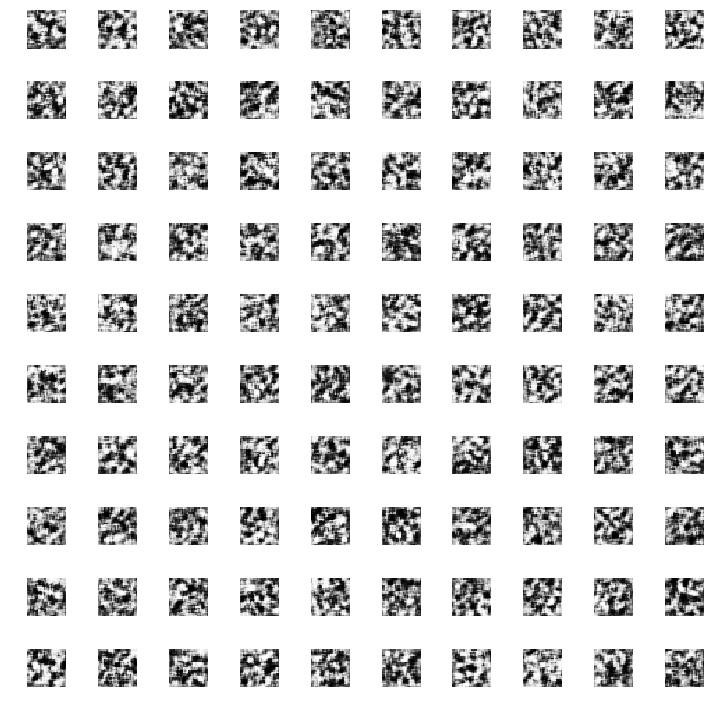

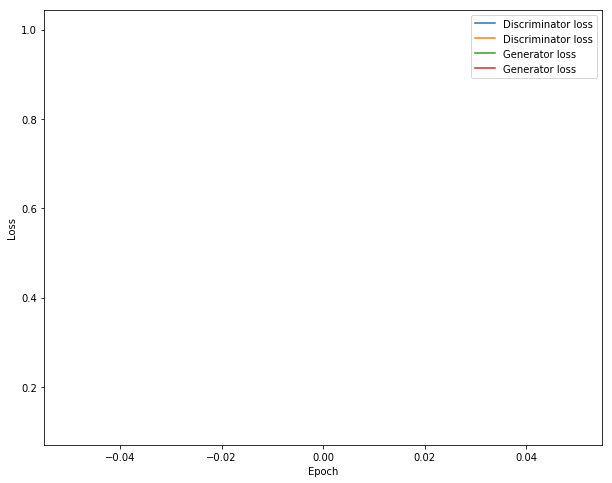

In [6]:
# set hyper parameters    
batch_size = 128
epochs = 1
learning_rate = 0.0002
z_input_dim = 100
n_iter_D = 1
n_iter_G = 1

# run model
model = Model(batch_size, epochs, learning_rate, z_input_dim, n_iter_D, n_iter_G)

print('\n[Start] {}'.format(datetime.now().strftime("%Y-%m-%d %H:%M:%S.%f"))) 
model.fit()
print('[End  ] {}'.format(datetime.now().strftime("%Y-%m-%d %H:%M:%S.%f"))) 
                                                  